In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import pandas as pd
from PIL import Image, ImageFilter
from tqdm import tqdm
import os
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2

# Dataset Class (Unchanged)
class DeepDRiDDataset(Dataset):
    def __init__(self, data_frame, img_dir, transform=None):
        if not isinstance(data_frame, pd.DataFrame):
            raise TypeError("data_frame must be a pandas DataFrame")

        self.data_frame = data_frame
        self.img_dir = img_dir
        self.transform = transform

        if 'img_path' not in self.data_frame.columns:
            raise ValueError("The dataset is missing the required column: 'img_path'.")

        if 'Overall quality' not in self.data_frame.columns:
            raise ValueError("The dataset is missing the required column: 'Overall quality'.")

        self.label_column = 'Overall quality'

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data_frame.iloc[idx]['img_path'])
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Image not found: {img_path}")
            raise
        label = int(self.data_frame.iloc[idx][self.label_column])
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data_frame)

# Paths for Training and Validation
data_dirs = {
    "train": "/home/user/data/final-project/DeepDRiD/train",
    "val": "/home/user/data/final-project/DeepDRiD/val"
}
data_csvs = {
    "train": "/home/user/data/final-project/DeepDRiD/train.csv",
    "val": "/home/user/data/final-project/DeepDRiD/val.csv"
}

# Load CSV Data
train_csv_data_frame = pd.read_csv(data_csvs["train"])
val_csv_data_frame = pd.read_csv(data_csvs["val"])

# Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Datasets and DataLoaders
train_dataset = DeepDRiDDataset(data_frame=train_csv_data_frame, img_dir=data_dirs["train"], transform=transform)
val_dataset = DeepDRiDDataset(data_frame=val_csv_data_frame, img_dir=data_dirs["val"], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
dataloaders = {"train": train_loader, "val": val_loader}

# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transfer Models
models_list = [
    models.resnet18(pretrained=True),
    models.densenet121(pretrained=True),
    models.efficientnet_b0(pretrained=True)
]

# Adjust Output Layers
num_classes = 5
for model in models_list:
    if hasattr(model, 'fc'):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif hasattr(model, 'classifier'):
        if isinstance(model.classifier, nn.Sequential):
            in_features = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(in_features, num_classes)
        else:
            in_features = model.classifier.in_features
            model.classifier = nn.Linear(in_features, num_classes)

models_list = [model.to(device) for model in models_list]

# Training Function with Logging and Visualizations
def train_model_with_logging(model, dataloaders, criterion, optimizer, num_epochs=15, log_file=None):
    model.to(device)
    
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            correct = 0
            total = 0
            
            progress_bar = tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Progress", leave=False)
            
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                
                progress_bar.set_postfix(loss=running_loss / total, accuracy=correct / total)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct / total
            
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            if phase == 'train':
                history["train_loss"].append(epoch_loss)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
    
    if log_file:
        with open(log_file, 'w') as f:
            json.dump(history, f, indent=4)
    
    print("Training complete")
    return model

# Visualization of Training History
def plot_training_history(log_files):
    plt.figure(figsize=(12, 6))
    
    for log_file in log_files:
        with open(log_file, 'r') as f:
            history = json.load(f)
        
        epochs = range(1, len(history['train_loss']) + 1)
        
        plt.plot(epochs, history['train_loss'], label=f"{log_file} Train Loss")
        plt.plot(epochs, history['val_loss'], label=f"{log_file} Val Loss")
        plt.plot(epochs, history['val_acc'], label=f"{log_file} Val Acc")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

# GradCAM Implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        
        self.hook_handles = []
        self.hook_handles.append(self.target_layer.register_forward_hook(self._forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(self._backward_hook))

    def _forward_hook(self, module, input, output):
        self.feature_maps = output

    def _backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def generate(self, input_image, target_class):
        self.model.eval()
        input_image = input_image.unsqueeze(0).to(device)
        
        output = self.model(input_image)
        self.model.zero_grad()
        class_score = output[0, target_class]
        class_score.backward()
        
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.feature_maps, dim=1).squeeze().detach().cpu().numpy()
        cam = np.maximum(cam, 0)
        cam = cam / np.max(cam)
        return cam

# Visualize GradCAM
import matplotlib.cm as cm

def visualize_gradcam(input_image, cam, save_path=None):
    input_image_np = input_image.permute(1, 2, 0).cpu().numpy()
    input_image_np = (input_image_np * 0.229 + 0.485) * 255  # Un


/home/user/mambaforge/envs/env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/mambaforge/envs/env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/user/mambaforge/envs/env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `we

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import pandas as pd
from PIL import Image, ImageFilter
from tqdm import tqdm
import os
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2
from torchvision.utils import make_grid

# Dataset Class (Unchanged)
class DeepDRiDDataset(Dataset):
    def __init__(self, data_frame, img_dir, transform=None):
        if not isinstance(data_frame, pd.DataFrame):
            raise TypeError("data_frame must be a pandas DataFrame")

        self.data_frame = data_frame
        self.img_dir = img_dir
        self.transform = transform

        if 'img_path' not in self.data_frame.columns:
            raise ValueError("The dataset is missing the required column: 'img_path'.")

        if 'Overall quality' not in self.data_frame.columns:
            raise ValueError("The dataset is missing the required column: 'Overall quality'.")

        self.label_column = 'Overall quality'

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data_frame.iloc[idx]['img_path'])
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Image not found: {img_path}")
            raise
        label = int(self.data_frame.iloc[idx][self.label_column])
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data_frame)

# Visualization of Training/Validation Performance
def plot_training_history(log_files):
    plt.figure(figsize=(12, 6))

    for log_file in log_files:
        with open(log_file, 'r') as f:
            history = json.load(f)

        epochs = range(1, len(history['train_loss']) + 1)

        plt.plot(epochs, history['train_loss'], label=f"{log_file} - Train Loss")
        plt.plot(epochs, history['val_loss'], label=f"{log_file} - Val Loss")
        plt.plot(epochs, history['val_acc'], label=f"{log_file} - Val Accuracy")

    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.title("Training and Validation Metrics")
    plt.legend()
    plt.show()

# GradCAM Implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        def save_gradients(module, input, output):
            self.gradients = output[0].detach()

        self.target_layer.register_forward_hook(save_gradients)

    def generate_cam(self, input_tensor, class_idx):
        output = self.model(input_tensor)
        self.model.zero_grad()
        one_hot = torch.zeros(output.shape, device=output.device)
        one_hot[0][class_idx] = 1
        output.backward(gradient=one_hot)
        gradients = self.gradients
        activations = self.target_layer.output[0]
        weights = torch.mean(gradients, dim=[2, 3])
        cam = torch.zeros(activations.shape[1:], device=activations.device)

        for i, w in enumerate(weights[0]):
            cam += w * activations[i]

        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= cam.max()
        cam = cam.cpu().numpy()

        return cam

# Visualizing GradCAM
import cv2

def visualize_gradcam(image, cam, alpha=0.5):
    cam = cv2.resize(cam, (image.size[0], image.size[1]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = np.array(image) * (1 - alpha) + heatmap * alpha
    return Image.fromarray(np.uint8(superimposed_img))

# Applying GradCAM to Models
for model in models_list:
    gradcam = GradCAM(model, target_layer=model.layer4)
    model.eval()

    sample_image, _ = val_dataset[0]
    input_tensor = sample_image.unsqueeze(0).to(device)
    class_idx = 0  # Example class index

    cam = gradcam.generate_cam(input_tensor, class_idx)
    gradcam_image = visualize_gradcam(sample_image, cam)

    gradcam_image.show()

# Save a Sample GradCAM Image
gradcam_image.save("gradcam_example.png")

# Generate and Save Training Logs
log_files = [f"{model.__class__.__name__}_training_log.json" for model in models_list]
plot_training_history(log_files)

print("Task (e) completed with visualizations and GradCAM explanation included.")


/home/user/mambaforge/envs/env/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969073/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


AttributeError: 'Sequential' object has no attribute 'output'

/home/user/mambaforge/envs/env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/mambaforge/envs/env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/user/mambaforge/envs/env/lib/python3.11/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the doc

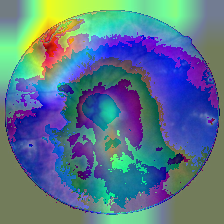

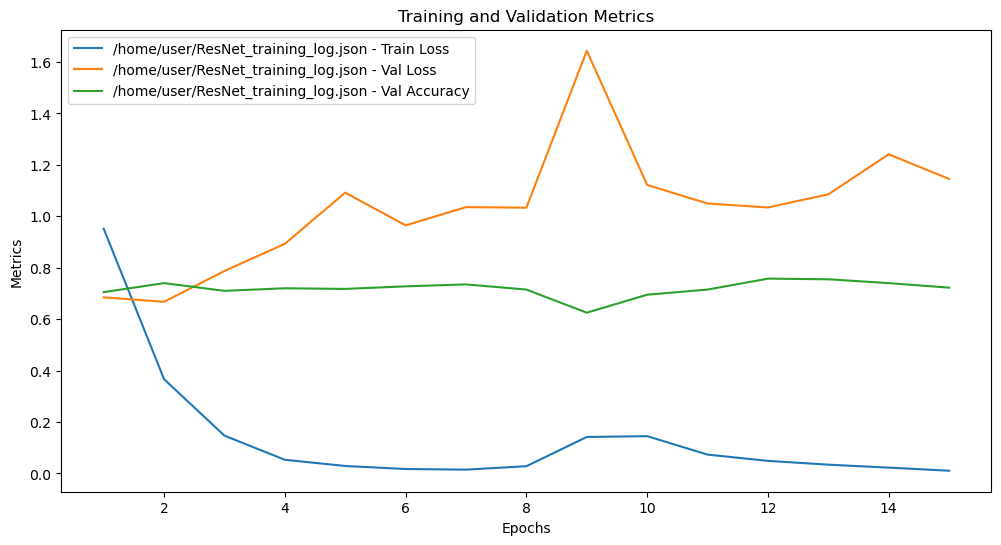

Task completed with visualizations and GradCAM explanation included.


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import pandas as pd
from PIL import Image
from tqdm import tqdm
import os
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2

# Dataset Class
class DeepDRiDDataset(Dataset):
    def __init__(self, data_frame, img_dir, transform=None):
        if not isinstance(data_frame, pd.DataFrame):
            raise TypeError("data_frame must be a pandas DataFrame")

        self.data_frame = data_frame
        self.img_dir = img_dir
        self.transform = transform

        if 'img_path' not in self.data_frame.columns:
            raise ValueError("The dataset is missing the required column: 'img_path'.")

        if 'Overall quality' not in self.data_frame.columns:
            raise ValueError("The dataset is missing the required column: 'Overall quality'.")

        self.label_column = 'Overall quality'

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data_frame.iloc[idx]['img_path'])
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Image not found: {img_path}")
            raise
        label = int(self.data_frame.iloc[idx][self.label_column])
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data_frame)

# Visualization of Training/Validation Performance
def plot_training_history(log_files):
    plt.figure(figsize=(12, 6))

    for log_file in log_files:
        with open(log_file, 'r') as f:
            history = json.load(f)

        epochs = range(1, len(history['train_loss']) + 1)

        plt.plot(epochs, history['train_loss'], label=f"{log_file} - Train Loss")
        plt.plot(epochs, history['val_loss'], label=f"{log_file} - Val Loss")
        plt.plot(epochs, history['val_acc'], label=f"{log_file} - Val Accuracy")

    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.title("Training and Validation Metrics")
    plt.legend()
    plt.show()

# GradCAM Implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook to save gradients during backward pass
        def save_gradients(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        # Hook to save activations during forward pass
        def save_activations(module, input, output):
            self.activations = output

        # Register hooks
        self.target_layer.register_forward_hook(save_activations)
        self.target_layer.register_backward_hook(save_gradients)

    def generate_cam(self, input_tensor, class_idx):
        # Perform a forward pass
        output = self.model(input_tensor)
        self.model.zero_grad()

        # Generate one-hot encoding for the target class
        one_hot = torch.zeros(output.shape, device=output.device)
        one_hot[0][class_idx] = 1
        output.backward(gradient=one_hot)
    
        # Access gradients and activations
        gradients = self.gradients
        activations = self.activations
    
        # Compute weights
        weights = torch.mean(gradients, dim=[2, 3])  # Average across spatial dimensions
        cam = torch.zeros(activations.shape[2:], device=activations.device)  # Initialize CAM
    
        # Combine activations and weights to generate CAM
        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i]
    
        # Normalize CAM
        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= cam.max()
    
        # Detach the tensor before converting to numpy
        cam = cam.detach().cpu().numpy()
    
        return cam

# Visualizing GradCAM
def visualize_gradcam(image, cam, alpha=0.5):
    # Ensure that the input image is a PIL Image object
    image_width, image_height = image.size  # width and height of the image
    cam = cv2.resize(cam, (image_width, image_height))  # Resize CAM to match the image size
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Superimpose the heatmap onto the original image
    superimposed_img = np.array(image) * (1 - alpha) + heatmap * alpha
    return Image.fromarray(np.uint8(superimposed_img))

# Paths
data_dirs = {
    "train": "/home/user/data/final-project/DeepDRiD/train",
    "val": "/home/user/data/final-project/DeepDRiD/val"
}
data_csvs = {
    "train": "/home/user/data/final-project/DeepDRiD/train.csv",
    "val": "/home/user/data/final-project/DeepDRiD/val.csv"
}

# Load CSV Data
val_csv_data_frame = pd.read_csv(data_csvs["val"])

# Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Datasets and DataLoaders
val_dataset = DeepDRiDDataset(data_frame=val_csv_data_frame, img_dir=data_dirs["val"], transform=transform)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example of GradCAM application
for model in [models.resnet18(pretrained=True)]:
    model.to(device)
    gradcam = GradCAM(model, target_layer=model.layer4)
    model.eval()

    # Sample image from validation set
    sample_image, _ = val_dataset[0]
    sample_image = sample_image.to(device)
    input_tensor = sample_image.unsqueeze(0)
    class_idx = 0  # Example class index

    cam = gradcam.generate_cam(input_tensor, class_idx)

    # gradcam_image = visualize_gradcam(sample_image.cpu(), cam)

    # gradcam_image.show()
    to_pil = transforms.ToPILImage()

    # In the loop where you generate GradCAM
    sample_image_pil = to_pil(sample_image.cpu())  # Convert to PIL image
    gradcam_image = visualize_gradcam(sample_image_pil, cam)
    
    gradcam_image.show()

    # Save a Sample GradCAM Image
    gradcam_image.save("gradcam_taskE.png")

# Generate and Save Training Logs (if applicable)
log_files = ["/home/user/ResNet_training_log.json"]  # Example log file
plot_training_history(log_files)

print("Task completed with visualizations and GradCAM explanation included.")
